In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

C:\Users\kayra\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("dataset (MSFT).csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (7779, 7)


,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
0,2022-09-19 09:30:00-04:00,242.464996,242.479996,242.000000,242.136002,242.136002,677274.0
1,2022-09-19 09:31:00-04:00,242.190002,242.589996,242.100006,242.544998,242.544998,81735.0
2,2022-09-19 09:32:00-04:00,242.315002,242.519104,242.190094,242.464996,242.464996,178308.0
3,2022-09-19 09:33:00-04:00,242.479996,242.615005,242.229996,242.399994,242.399994,22108.0
4,2022-09-19 09:34:00-04:00,242.169998,242.589798,242.169998,242.361206,242.361206,148771.0


In [3]:
training_set = df.iloc[:5446, 1:5].values
test_set = df.iloc[5446:, 1:5].values

print(training_set.shape)
print(test_set.shape)

(5446, 4)
(2333, 4)


In [13]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 5446):
    X_train.append(training_set_scaled[i-60:i, 0:4])
    y_train.append(training_set_scaled[i, 0:4])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
#(840, 60, 1)
X_train.shape

(5386, 60, 4)

In [46]:
# Feature Scaling
# sc2 = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set[:, 0:])
# # Creating a data structure with 60 time-steps and 1 output
# X_train = []
# y_train = []
# for i in range(60, 5446):
#     X_train.append(training_set_scaled[i-60][0:4])
#     y_train.append(training_set_scaled[i][0:4])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
#(840, 60, 1)
# X_train.shape

In [14]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 4)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 4))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
169/169 [==============================] - 33s 144ms/step - loss: 0.0169
Epoch 2/100
169/169 [==============================] - 25s 149ms/step - loss: 0.0064
Epoch 3/100
169/169 [==============================] - 26s 155ms/step - loss: 0.0053
Epoch 4/100
169/169 [==============================] - 29s 170ms/step - loss: 0.0042
Epoch 5/100
169/169 [==============================] - 27s 159ms/step - loss: 0.0041
Epoch 6/100
169/169 [==============================] - 25s 149ms/step - loss: 0.0033
Epoch 7/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0030
Epoch 8/100
169/169 [==============================] - 26s 154ms/step - loss: 0.0029
Epoch 9/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0025
Epoch 10/100
169/169 [==============================] - 26s 153ms/step - loss: 0.0023
Epoch 11/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0022
Epoch 12/100
169/169 [==============================] - 26s 155

169/169 [==============================] - 26s 152ms/step - loss: 5.9426e-04
Epoch 94/100
169/169 [==============================] - 27s 158ms/step - loss: 5.9283e-04
Epoch 95/100
169/169 [==============================] - 26s 152ms/step - loss: 5.9374e-04
Epoch 96/100
169/169 [==============================] - 26s 151ms/step - loss: 5.7421e-04
Epoch 97/100
169/169 [==============================] - 25s 150ms/step - loss: 5.9082e-04
Epoch 98/100
169/169 [==============================] - 26s 154ms/step - loss: 5.6996e-04
Epoch 99/100
169/169 [==============================] - 26s 153ms/step - loss: 6.0066e-04
Epoch 100/100
169/169 [==============================] - 26s 151ms/step - loss: 6.0354e-04


In [15]:
model.save('Models/11-29-2022')

INFO:tensorflow:Assets written to: Models/11-29-2022\assets


INFO:tensorflow:Assets written to: Models/11-29-2022\assets


In [16]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:5446, 1:5]
dataset_test = df.iloc[5446:, 1:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,4)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 2393):
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
print(X_test.shape)
# (300, 60, 1)
X_test.shape

(2333, 60, 4)


(2333, 60, 4)

In [17]:
predicted_stock_price = model.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

73/73 [==============================] - 5s 41ms/step


(2333, 4)

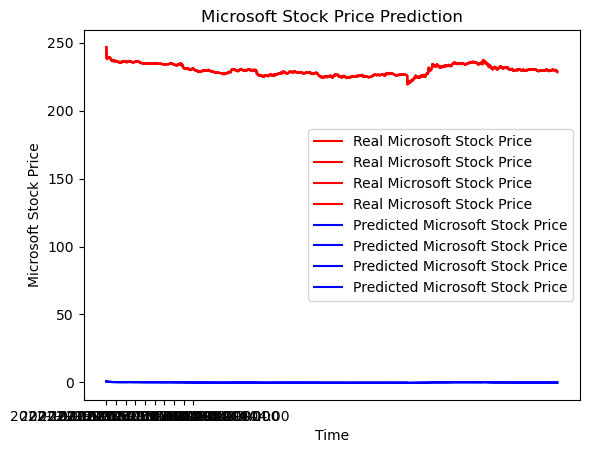

In [18]:
# Visualising the results
plt.plot(df.loc[5446:, 'Unnamed: 0'],dataset_test.values, color = 'red', label = 'Real Microsoft Stock Price')
plt.plot(df.loc[5446:, 'Unnamed: 0'],predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()

In [26]:
predicted_prices_df =pd.DataFrame(predicted_stock_price, columns = ['Price'])
predicted_prices_df.to_csv (r'C:\Users\kayra\OneDrive\Desktop\Stonks 2022\2022-2023-Stocks-Prediction\Predictions\Close Price Prediction.csv', index = False, header=True)